In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import numpy as np
import makassar_ml as ml
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
sns.set() # Use seaborn themes.

In [3]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [4]:
def fuse_dated_images_timeseries(
    ds_images_dates: tf.data.Dataset,
    df_timeseries: pd.DataFrame,
    timedelta_dict: dict, # i.e., {'days':1, 'hours':24, 'minutes':5}
    datetime_column: str = 'datetime',
    datetime_format: str = '%Y-%m-%d %H:%M:%S',
    features: list[str] = None,
    ):

    # Set the index to datetime so lookup is quicker.
    df_timeseries_datetimeindex = df_timeseries.set_index([datetime_column])

    def gen():
        for (image, date), label in ds_images_dates:
            end_date = dt.datetime.strptime(date.numpy().decode('utf8'), datetime_format)
            start_date = end_date - dt.timedelta(**timedelta_dict)
            df_timeseries_range = df_timeseries_datetimeindex.loc[start_date:end_date]
            df_timeseries_range.reset_index(inplace=True)
            if features is not None:
                df_timeseries_range = df_timeseries_range[features]
            tensor_timeseries_range = tf.convert_to_tensor(df_timeseries_range)
            yield ((image, tensor_timeseries_range), label)

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), # image
                tf.TensorSpec(shape=(None, None), dtype=tf.float32), # timeseries
            ),
            tf.TensorSpec(shape=(), dtype=tf.int64), # label
        ),
    )

In [5]:
# Load image dataset.
ds_images, info = tfds.load(
    name='plant_village',
    split='train',
    as_supervised=True,
    with_info=True,
    shuffle_files=False,
)

# Load weather dataset.
df_weather = ml.datasets.beijingpm25.load_beijingpm25_df(
    path=Path("~/research/makassar/datasets/beijing_pm25").expanduser(),
)

In [6]:
# Generate random distribution of dates to associated with the images.
reserve_offset_index = 0
timeseries_datetime_column = 'datetime'
n_images = int(ds_images.cardinality())
random_dates = df_weather.iloc[reserve_offset_index:].sample(n=n_images, replace=True)[timeseries_datetime_column]

Text(0, 0.5, 'count')

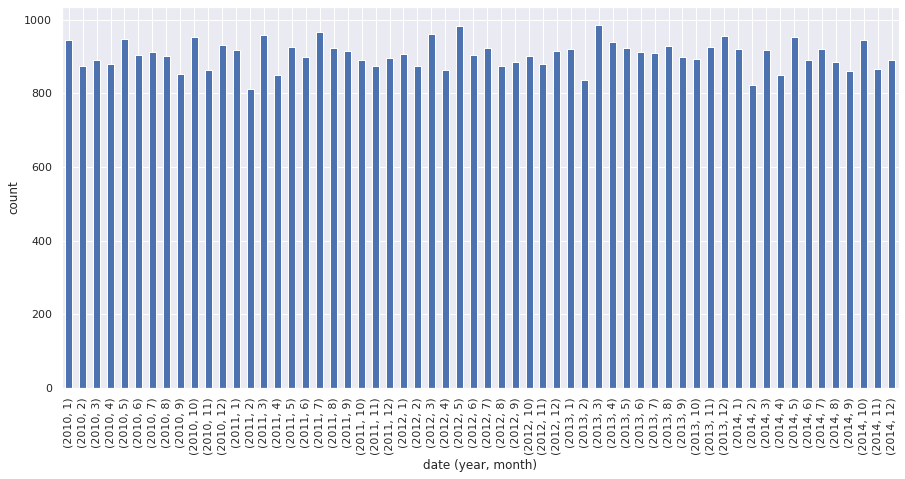

In [7]:
# Plot distribution of dates.
plt.figure(figsize=(15,7))
random_dates.groupby([random_dates.dt.year, random_dates.dt.month]).count().plot(kind="bar")
plt.xlabel('date (year, month)')
plt.ylabel('count')

In [8]:
# Fuse images with dates.
ds_images_dates = tf.data.Dataset.zip(
        (ds_images, tf.data.Dataset.from_tensor_slices(random_dates.astype(str)))
    ).map(
        lambda image_label, datestring: ((image_label[0], datestring), image_label[1]) # Reorder to ((image, date), label).
    )

In [9]:
for (image, date), label in ds_images_dates.batch(128).take(5):
    print(image.shape)
    print(label.shape)
    print(date.shape)
    break

(128, 256, 256, 3)
(128,)
(128,)


In [10]:
temp = fuse_dated_images_timeseries(
    ds_images_dates=ds_images_dates, 
    df_timeseries=df_weather,
    timedelta_dict=dict(hours=72),
    features=['DEWP', 'TEMP','PRES','Iws','Is','Ir'],
)
for (image, data), label in temp.batch(128).take(1):
    print(image.shape, data.shape, label.shape)
    break

(128, 256, 256, 3) (128, 73, 6) (128,)
